In [499]:
import torch
import matplotlib.pyplot as plt
from graphxai.datasets import ShapeGGen

In [500]:
dataset = ShapeGGen(
    model_layers = 2,
    num_subgraphs = 20,
    subgraph_size = 15,
    prob_connection = 0.3,
    add_sensitive_feature = False
)


  0%|          | 0/97 [00:00<?, ?it/s]

100%|██████████| 97/97 [00:00<00:00, 540.09it/s]


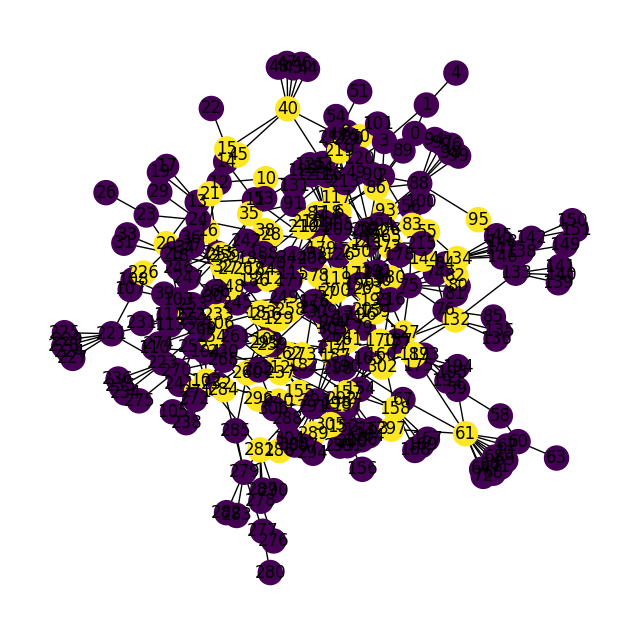

In [501]:
plt.figure(figsize = (8, 8))
dataset.visualize(show = True)

In [502]:
from torch_geometric.nn import GCNConv

class MyGNN(torch.nn.Module):
    def __init__(self, input_feat, hidden_channels, classes = 2):
        super(MyGNN, self).__init__()
        self.gin1 = GCNConv(input_feat, hidden_channels)
        self.gin2 = GCNConv(hidden_channels, classes)

    def forward(self, x, edge_index):
        # NOTE: our provided testing function assumes no softmax
        #   output from the forward call.
        x = self.gin1(x, edge_index)
        x = x.relu()
        x = self.gin2(x, edge_index)
        return x

In [503]:
from graphxai.gnn_models.node_classification import train, test

data = dataset.get_graph(use_fixed_split=True)

model = MyGNN(dataset.n_features, 32)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.001)
criterion = torch.nn.CrossEntropyLoss()

# Train model:
for _ in range(1000):
    loss = train(model, optimizer, criterion, data)

# Final testing performance:
f1, acc, prec, rec, auprc, auroc = test(model, data, num_classes = 2, get_auc = True)

print('Test F1 score: {:.4f}'.format(f1))
print('Test AUROC: {:.4f}'.format(auroc))

Test F1 score: 0.6061
Test AUROC: 0.7786


In [504]:
data

Data(x=[310, 10], edge_index=[2, 854], y=[310], shape=[310], train_mask=[310], valid_mask=[310], test_mask=[310])

In [505]:
from torch_geometric.explain import Explainer, GNNExplainer

explainer = Explainer(
    model=model,
    explanation_type=(
        "model"
    ),
    algorithm=GNNExplainer(
        epochs=200,
        lr=0.01,
    ),
    node_mask_type="object",
    edge_mask_type="object",
    model_config=dict(
        mode="multiclass_classification",
        task_level="node",
        return_type="probs",
    ),
)



In [506]:
node_idx, gt_exp = dataset.choose_node(split = 'test')

In [507]:

from torch_geometric.utils import k_hop_subgraph

In [508]:
explanation = explainer(data.x, data.edge_index, index=node_idx)

subset, edge_index, mapping, hard_edge_mask = k_hop_subgraph(node_idx, num_hops=2,edge_index=data.edge_index)

In [509]:
gt_exp[0].edge_imp.size()

torch.Size([30])

In [510]:
gt_edge_mask = gt_exp[0].edge_imp

In [511]:
pred_edge_mask = []
for i in range(len(hard_edge_mask)):
    if hard_edge_mask[i]:
        pred_edge_mask.append(explanation.edge_mask[i])
        
pred_edge_mask = torch.stack(pred_edge_mask)
pred_edge_mask.shape

torch.Size([30])

In [512]:
pred_edge_mask

tensor([0.0751, 0.8981, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.8587, 0.0000, 0.0000, 0.0000, 0.0000,
        0.9215, 0.9012, 0.8948, 0.0855, 0.8649, 0.0759, 0.8528, 0.9238, 0.8575,
        0.8740, 0.9071, 0.0862])

In [513]:
k = int(0.25*len(pred_edge_mask))
pred_edge_mask.topk(k).values.min()

tensor(0.8740)

In [514]:
# pred_edge_mask = (pred_edge_mask >= pred_edge_mask.topk(k).values.min()).float()
pred_edge_mask = (pred_edge_mask >= 0.5).float()

In [515]:
pred_edge_mask

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0.])

In [516]:
from sklearn.metrics import roc_auc_score, jaccard_score

auc = roc_auc_score(gt_edge_mask, pred_edge_mask)
jacc = jaccard_score(gt_edge_mask, pred_edge_mask)

auc, jacc

(0.5249999999999999, 0.23529411764705882)

# COmplex

In [517]:
from data import graph_to_complex

In [518]:
og_num_nodes = data.x.shape[0]
complex_data, mapping = graph_to_complex(data)
complex_data = complex_data.to_homogeneous()
final_num_nodes = complex_data.x.shape[0]

extension = final_num_nodes - og_num_nodes
extension

894

In [519]:
# pad the y, train mask, val mask, test mask
complex_data.y = torch.cat([complex_data.y, torch.zeros(extension, dtype = torch.long)])
complex_data.train_mask = torch.cat([data.train_mask, torch.zeros(extension, dtype = torch.bool)])
complex_data.val_mask = torch.cat([data.valid_mask, torch.zeros(extension, dtype = torch.bool)])
complex_data.test_mask = torch.cat([data.test_mask, torch.zeros(extension, dtype = torch.bool)])

In [520]:
complex_data

Data(y=[1204], edge_index=[2, 2902], x=[1204, 10], node_type=[1204], edge_type=[2902], train_mask=[1204], val_mask=[1204], test_mask=[1204])

In [521]:
from graphxai.gnn_models.node_classification import train, test

data = dataset.get_graph(use_fixed_split=True)

model = MyGNN(dataset.n_features, 32)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.001)
criterion = torch.nn.CrossEntropyLoss()

# Train model:
for _ in range(1000):
    loss = train(model, optimizer, criterion, complex_data)

# Final testing performance:
f1, acc, prec, rec, auprc, auroc = test(model, complex_data, num_classes = 2, get_auc = True)

print('Test F1 score: {:.4f}'.format(f1))
print('Test AUROC: {:.4f}'.format(auroc))

Test F1 score: 0.6471
Test AUROC: 0.7759


In [522]:
from torch_geometric.explain import Explainer, GNNExplainer

explainer = Explainer(
    model=model,
    explanation_type=(
        "model"
    ),
    algorithm=GNNExplainer(
        epochs=200,
        lr=0.01,
    ),
    node_mask_type="object",
    edge_mask_type="object",
    model_config=dict(
        mode="multiclass_classification",
        task_level="node",
        return_type="probs",
    ),
)

In [523]:
from torch_geometric.utils import k_hop_subgraph

In [524]:
explanation = explainer(complex_data.x, complex_data.edge_index, index=node_idx)

_, _, _, hard_edge_mask = k_hop_subgraph(node_idx, num_hops=2,edge_index=complex_data.edge_index)

In [525]:
gt_edge_mask.shape

torch.Size([30])

In [526]:
def remove_type_2_nodes(data):
    """
    Removes nodes of type '2' which are assumed to be at the end of the node list.
    All edges connected to these nodes are also removed.
    
    Parameters:
    - data (Data): The input graph data object.
    
    Returns:
    - Data: The updated graph data object with type '2' nodes and associated edges removed.
    """
    if 2 not in data.node_type:
        return data

    # Determine the cutoff index where nodes of type '2' start
    # Since type '2' nodes are at the end, find the first occurrence of '2' in the node_type array
    cutoff_index = (data.node_type == 2).nonzero(as_tuple=True)[0][0]
    
    # Update node features and types by excluding type '2' nodes
    data.x = data.x[:cutoff_index]
    data.node_type = data.node_type[:cutoff_index]
    
    # Create a mask for edges to keep only those that do not connect to type '2' nodes
    edge_mask = data.edge_index[0] < cutoff_index
    edge_mask &= data.edge_index[1] < cutoff_index
    
    # Apply the mask to edge_index and edge_type
    data.edge_index = data.edge_index[:, edge_mask]
    data.edge_type = data.edge_type[edge_mask]
    
    return data

In [527]:
def spread_direct_prop(graph, explanation, mapping):
    edge_mask = explanation["edge_mask"]
    edge_type = graph.edge_type

    num_og_edges = (edge_type == 0).sum().item()
    new_edge_mask = torch.zeros(num_og_edges)

    # print(num_og_edges, new_edge_mask)

    last_seen = -1
    counter = 0
    for i in range(len(edge_type)):
        if edge_type[i] == 0:
            new_edge_mask[i] = edge_mask[i]

        if edge_type[i] == 1:
            if last_seen != 1:
                counter = 0
            else:
                counter += 1

            idx = mapping[1][counter]
            new_edge_mask[idx] += edge_mask[i]
        elif edge_type[i] == 2:
            if last_seen != 2:
                counter = 0
            else:
                counter += 1

            idx = mapping[2][counter]
            new_edge_mask[idx] += edge_mask[i]
        elif edge_type[i] == 3:
            if last_seen != 3:
                counter = 0
            else:
                counter += 1

            # print('ERRROR', i)
            # print(edge_type[i], edge_type[i + 1])
            idx_list = mapping[3][counter]
            for idx in idx_list:
                new_edge_mask[idx] += edge_mask[i]
        elif edge_type[i] == 4:
            if last_seen != 4:
                counter = 0
            else:
                counter += 1

            idx_list = mapping[4][counter]
            for idx in idx_list:
                new_edge_mask[idx] += edge_mask[i]

        last_seen = edge_type[i]

    return new_edge_mask

In [528]:
std_edge_mask = (spread_direct_prop(remove_type_2_nodes(complex_data), explanation, mapping) / 3.5).tanh()

In [529]:
pred_edge_mask = []
for i in range(len(std_edge_mask)):
    if hard_edge_mask[i]:
        pred_edge_mask.append(explanation.edge_mask[i])
pred_edge_mask = torch.stack(pred_edge_mask)
pred_edge_mask.shape

torch.Size([30])

In [530]:
pred_edge_mask

tensor([0.1007, 0.8760, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.8987, 0.0000, 0.0000, 0.0000, 0.0000,
        0.1403, 0.8909, 0.8830, 0.8975, 0.8847, 0.8719, 0.9222, 0.0912, 0.9266,
        0.0918, 0.8905, 0.1301])

In [531]:
k = int(0.25*len(pred_edge_mask))
# pred_edge_mask = (pred_edge_mask >= pred_edge_mask.topk(k).values.min()).float()
pred_edge_mask = (pred_edge_mask >= 0.5).float()

In [532]:
gt_exp[0].edge_imp.size()

torch.Size([30])

In [533]:
pred_edge_mask, gt_edge_mask

(tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
         1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=torch.float64))

In [534]:
gt_edge_mask = gt_exp[0].edge_imp

jaccard = jaccard_score(gt_edge_mask, pred_edge_mask)
print('Jaccard similarity:', jaccard)

Jaccard similarity: 0.17647058823529413


In [535]:
auc = roc_auc_score(gt_edge_mask, pred_edge_mask)
auc

0.47500000000000003

In [2]:
from sklearn.metrics import jaccard_score

In [4]:
jaccard_score(
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1 ],
    [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0 ],
)

0.125